# Estimativa Salarial Usando Modelos de Regressão

## Imports

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree

## Dataset

In [139]:
df = pd.read_csv('data_cleaned_2021.csv')

## Análise inicial


In [140]:
df.shape

(742, 42)

In [141]:
df.head()

,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,tensor,hadoop,tableau,bi,flink,mongo,google_an,job_title_sim,seniority_by_title,Degree
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 - 1000,1973,...,0,0,1,1,0,0,0,data scientist,na,M
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+,1984,...,0,0,0,0,0,0,0,data scientist,na,M
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 - 1000,2010,...,0,0,0,0,0,0,0,data scientist,na,M
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 - 5000,1965,...,0,0,0,0,0,0,0,data scientist,na,na
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 - 200,1998,...,0,0,0,0,0,0,0,data scientist,na,na


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               742 non-null    int64  
 1   Job Title           742 non-null    object 
 2   Salary Estimate     742 non-null    object 
 3   Job Description     742 non-null    object 
 4   Rating              742 non-null    float64
 5   Company Name        742 non-null    object 
 6   Location            742 non-null    object 
 7   Headquarters        742 non-null    object 
 8   Size                742 non-null    object 
 9   Founded             742 non-null    int64  
 10  Type of ownership   742 non-null    object 
 11  Industry            742 non-null    object 
 12  Sector              742 non-null    object 
 13  Revenue             742 non-null    object 
 14  Competitors         742 non-null    object 
 15  Hourly              742 non-null    int64  
 16  Employer

In [143]:
df.describe()

,index,Rating,Founded,Hourly,Employer provided,Lower Salary,Upper Salary,Avg Salary(K),Age,Python,...,keras,pytorch,scikit,tensor,hadoop,tableau,bi,flink,mongo,google_an
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,...,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,469.129380,3.618868,1837.154987,0.032345,0.022911,74.754717,128.214286,101.484501,47.524259,0.528302,...,0.039084,0.052561,0.072776,0.097035,0.167116,0.199461,0.075472,0.013477,0.049865,0.018868
std,279.793117,0.801210,497.183763,0.177034,0.149721,30.945892,45.128650,37.482449,53.839080,0.499535,...,0.193925,0.223305,0.259944,0.296205,0.373331,0.399865,0.264329,0.115384,0.217813,0.136150
min,0.000000,-1.000000,-1.000000,0.000000,0.000000,15.000000,16.000000,15.500000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,221.500000,3.300000,1939.000000,0.000000,0.000000,52.000000,96.000000,73.500000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,472.500000,3.700000,1988.000000,0.000000,0.000000,69.500000,124.000000,97.500000,25.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,707.750000,4.000000,2007.000000,0.000000,0.000000,91.000000,155.000000,122.500000,60.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,955.000000,5.000000,2019.000000,1.000000,1.000000,202.000000,306.000000,254.000000,277.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [144]:
df.isnull().sum() * 100 / df.shape[0]

,0
index,0.0
Job Title,0.0
Salary Estimate,0.0
Job Description,0.0
Rating,0.0
Company Name,0.0
Location,0.0
Headquarters,0.0
Size,0.0
Founded,0.0


<Axes: >

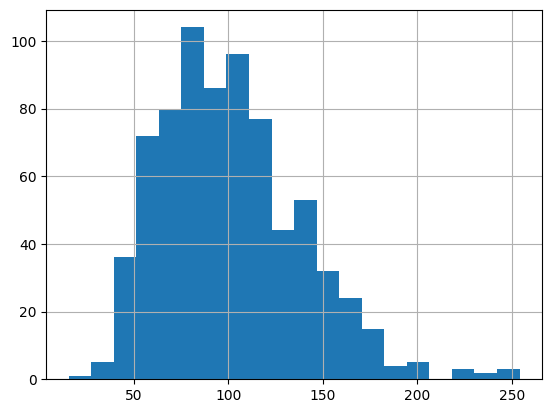

In [145]:
df['Avg Salary(K)'].hist(bins=20)

## Pré-processamento e limpeza

In [146]:
# Como tratar elementos nulos?
df_clean = df.dropna(axis=0)

# Quais colunas devem ser removidas?
# features = df_clean.drop(columns=['index', 'Salary Estimate', 'Job Description', 'Company Name', 'Lower Salary', 'Upper Salary'])
features = df_clean[['Job Title']]
target = df_clean['Avg Salary(K)']

# Como tratar colunas categóricas:
features_encoded = pd.get_dummies(features, drop_first=True)

## Datasets de treino e teste

In [147]:
# Divida os dados em conjuntos de treinamento e teste:
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

## Treinamento e teste

### GridSearch e Cross-validation

#### Ridge (Regressão Linear com regularização L2)

In [148]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_pred_lin = lr.predict(X_test)

param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

ridge = Ridge(random_state=42)

grid_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid_ridge,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0, 100.0]}, scoring='r2',
             verbose=1)

#### Árvore de decisão

In [149]:
# dt = DecisionTreeRegressor(max_depth=4, random_state=42)
# dt.fit(X_train, y_train)
# y_pred_tree = dt.predict(X_test)

param_grid_dt = {
    'max_depth': [None, 1, 2, 3, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01],
    'max_leaf_nodes': [None, 10, 20, 30]
}

dt = DecisionTreeRegressor(random_state=42)

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.001, 0.005, 0.01],
                         'max_depth': [None, 1, 2, 3, 4],
                         'max_features': [None, 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2', verbose=1)

#### Random forest

In [151]:
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_test)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 2, 3, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.001, 0.01]
}

rf = RandomForestRegressor(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.001, 0.01],
                         'max_depth': [None, 2, 3, 4],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2', verbose=1)

### Combinações de parâmetros

In [152]:
results_ridge = pd.DataFrame(grid_ridge.cv_results_)
results_ridge = results_ridge.sort_values(by='mean_test_score', ascending=False)
results_ridge.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018973,0.007139,0.004513,0.000550,0.1,{'alpha': 0.1},0.534692,0.634088,0.693555,0.430464,0.604833,0.579526,0.090388,1
1,0.013762,0.000996,0.004083,0.000091,1.0,{'alpha': 1.0},0.448125,0.516883,0.574813,0.389613,0.504581,0.486803,0.063101,2
2,0.014373,0.000718,0.004238,0.000143,10.0,{'alpha': 10.0},0.173389,0.181877,0.214908,0.168032,0.197717,0.187185,0.017116,3
3,0.014159,0.000669,0.004542,0.001660,100.0,{'alpha': 100.0},0.029306,0.035864,0.023417,0.027389,0.040526,0.031300,0.006122,4


In [153]:
results_dt = pd.DataFrame(grid_dt.cv_results_)
results_dt = results_dt.sort_values(by='mean_test_score', ascending=False)
results_dt.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1694,0.007504,0.000107,0.003524,0.000149,0.010,None,log2,None,1,10,"{'ccp_alpha': 0.01, 'max_depth': None, 'max_fe...",0.536326,0.633372,0.734736,0.411940,0.591982,0.581671,0.106839,1
1154,0.007259,0.000181,0.003514,0.000092,0.005,None,log2,None,1,10,"{'ccp_alpha': 0.005, 'max_depth': None, 'max_f...",0.536053,0.633372,0.734736,0.411940,0.591982,0.581616,0.106862,2
74,0.008410,0.001496,0.004128,0.001079,0.000,None,log2,None,1,10,"{'ccp_alpha': 0.0, 'max_depth': None, 'max_fea...",0.536053,0.633372,0.734736,0.411940,0.591982,0.581616,0.106862,2
614,0.007751,0.000379,0.003807,0.000244,0.001,None,log2,None,1,10,"{'ccp_alpha': 0.001, 'max_depth': None, 'max_f...",0.536053,0.633372,0.734736,0.411940,0.591982,0.581616,0.106862,2
1657,0.008539,0.000270,0.003514,0.000095,0.010,None,sqrt,None,1,5,"{'ccp_alpha': 0.01, 'max_depth': None, 'max_fe...",0.520200,0.608631,0.747643,0.357993,0.604346,0.567762,0.127774,5


In [154]:
results_rf = pd.DataFrame(grid_rf.cv_results_)
results_rf = results_rf.sort_values(by='mean_test_score', ascending=False)
results_rf.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
708,0.192815,0.007362,0.015558,0.001645,0.010,None,log2,1,10,50,"{'ccp_alpha': 0.01, 'max_depth': None, 'max_fe...",0.481744,0.577908,0.654025,0.368048,0.558452,0.528035,0.096979,1
60,0.177565,0.005042,0.015000,0.000972,0.000,None,log2,1,10,50,"{'ccp_alpha': 0.0, 'max_depth': None, 'max_fea...",0.481746,0.577907,0.654023,0.368065,0.558427,0.528033,0.096971,2
384,0.213880,0.021822,0.018777,0.005769,0.001,None,log2,1,10,50,"{'ccp_alpha': 0.001, 'max_depth': None, 'max_f...",0.481744,0.577909,0.654030,0.368051,0.558427,0.528032,0.096978,3
386,0.884157,0.120393,0.062719,0.016453,0.001,None,log2,1,10,200,"{'ccp_alpha': 0.001, 'max_depth': None, 'max_f...",0.483612,0.556624,0.654043,0.373988,0.560123,0.525678,0.093168,4
710,0.809181,0.079650,0.060652,0.018608,0.010,None,log2,1,10,200,"{'ccp_alpha': 0.01, 'max_depth': None, 'max_fe...",0.483602,0.556617,0.654052,0.373993,0.560124,0.525677,0.093169,5


### Resultados e predição

In [155]:
print("Ridge →", grid_ridge.best_params_, " | Best Score (neg MSE):", grid_ridge.best_score_)
print("Decision Tree →", grid_dt.best_params_, " | Best Score (neg MSE):", grid_dt.best_score_)
print("Random Forest →", grid_rf.best_params_, " | Best Score (neg MSE):", grid_rf.best_score_)

best_ridge = grid_ridge.best_estimator_
best_dt = grid_dt.best_estimator_
best_rf = grid_rf.best_estimator_

y_pred_ridge = best_ridge.predict(X_test)
y_pred_dt = best_dt.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

Ridge → {'alpha': 0.1}  | Best Score (neg MSE): 0.5795264665949146
Decision Tree → {'ccp_alpha': 0.01, 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 10}  | Best Score (neg MSE): 0.5816709898126979
Random Forest → {'ccp_alpha': 0.01, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}  | Best Score (neg MSE): 0.5280353461147078


## Medidas de desempenho

In [156]:
def print_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

print_metrics(y_test, y_pred_lin, "LR") # Regressão Linear
print_metrics(y_test, y_pred_tree, "DT") # Árvore de decisão
print_metrics(y_test, y_pred_rf, "RF") # Random Forest

LR -> MAE: 14.29, MSE: 635.37, RMSE: 25.21, R²: 0.5949
DT -> MAE: 28.90, MSE: 1390.62, RMSE: 37.29, R²: 0.1134
RF -> MAE: 18.51, MSE: 720.78, RMSE: 26.85, R²: 0.5405


## Plot

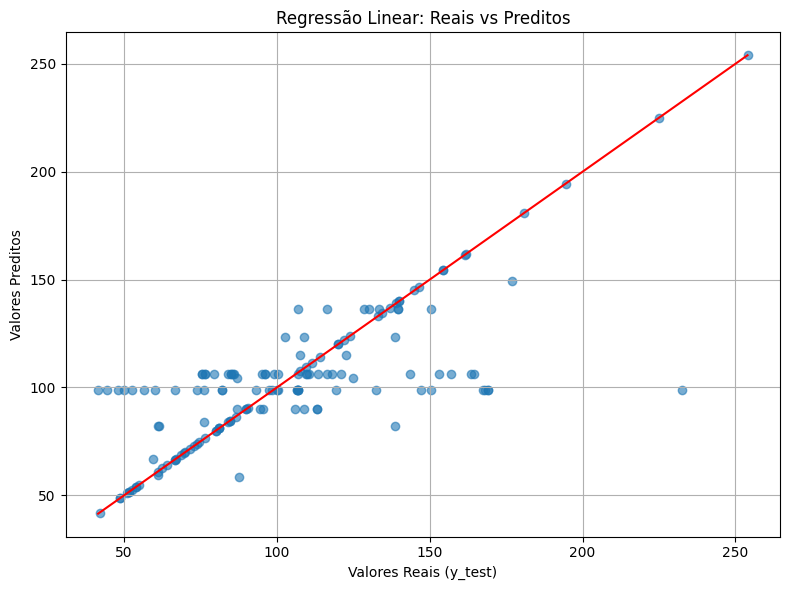

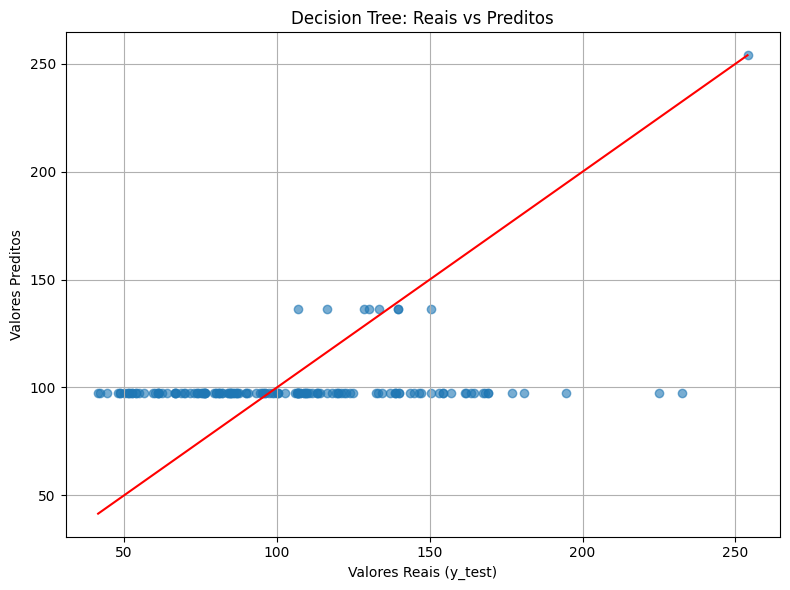

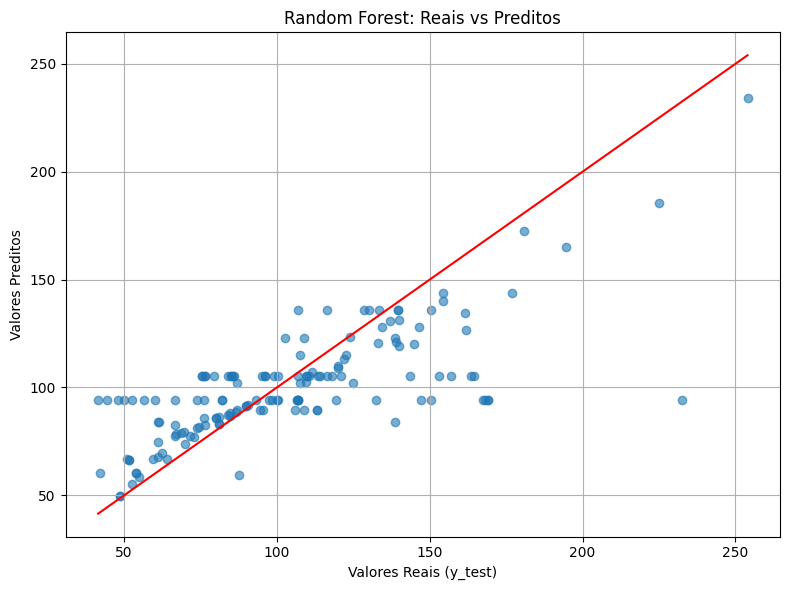

In [157]:
def plot_predicted_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)

    lim_min = min(y_true.min(), y_pred.min())
    lim_max = max(y_true.max(), y_pred.max())
    plt.plot([lim_min, lim_max], [lim_min, lim_max], color='red')

    plt.xlabel("Valores Reais (y_test)")
    plt.ylabel("Valores Preditos")
    plt.title(f"{model_name}: Reais vs Preditos")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predicted_vs_actual(y_test, y_pred_lin, "Regressão Linear")
plot_predicted_vs_actual(y_test, y_pred_tree, "Decision Tree")
plot_predicted_vs_actual(y_test, y_pred_rf, "Random Forest")